# 05 — Time Series Forecasting with ARIMA (PM2.5)
Mục tiêu:
- Làm sạch + chuẩn hoá chuỗi theo tần suất giờ (hourly) và xử lý missing.
- Kiểm tra **trend / seasonality / stationarity** (ADF, KPSS), ACF/PACF.
- Chọn tham số **(p,d,q)** bằng grid nhỏ (AIC/BIC) và dự báo bằng **ARIMA**.

> Lưu ý: Notebook này **chỉ dùng ARIMA** (statsmodels). 


In [15]:
from pathlib import Path
import os

# Thiết lập PROJECT_ROOT là thư mục lab4
PROJECT_ROOT = Path(r'D:\HocTap\Data-mining\lab4_an\lab4').resolve()
os.chdir(PROJECT_ROOT)

USE_UCIMLREPO = False
RAW_ZIP_PATH = PROJECT_ROOT / 'data' / 'raw' / 'PRSA2017_Data_20130301-20170228.zip'

STATION = 'Aotizhongxin'
VALUE_COL = 'PM2.5'
CUTOFF = '2017-01-01'

P_MAX = 3
Q_MAX = 3
D_MAX = 2
IC = 'aic'   # 'aic' or 'bic'

ARTIFACTS_PREFIX = 'arima_pm25'

print("PROJECT_ROOT =", PROJECT_ROOT)
print("RAW_ZIP_PATH =", RAW_ZIP_PATH)
print("File exists:", RAW_ZIP_PATH.exists())

PROJECT_ROOT = D:\HocTap\Data-mining\lab4_an\lab4
RAW_ZIP_PATH = D:\HocTap\Data-mining\lab4_an\lab4\data\raw\PRSA2017_Data_20130301-20170228.zip
File exists: True


In [16]:
import sys
import os
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Thêm thư mục gốc của project vào path
sys.path.insert(0, str(PROJECT_ROOT))

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller, kpss

from src.classification_library import (
    load_beijing_air_quality,
    clean_air_quality_df,
)
from src.timeseries_library import (
    StationSeriesConfig,
    make_hourly_station_series,
    describe_time_series,
    train_test_split_series,
    grid_search_arima_order,
    fit_arima_and_forecast,
)

print("PROJECT_ROOT =", PROJECT_ROOT)
print("RAW_ZIP_PATH =", RAW_ZIP_PATH)

PROJECT_ROOT = D:\HocTap\Data-mining\lab4_an\lab4
RAW_ZIP_PATH = D:\HocTap\Data-mining\lab4_an\lab4\data\raw\PRSA2017_Data_20130301-20170228.zip


## 1) Load + clean + build 1 chuỗi theo station
Chúng ta dự báo **một** chuỗi (một trạm) để ARIMA đúng nghĩa univariate.

In [17]:
df = load_beijing_air_quality(use_ucimlrepo=False, raw_zip_path=str((PROJECT_ROOT / RAW_ZIP_PATH).resolve()))
df = clean_air_quality_df(df)
cfg = StationSeriesConfig(station=STATION, value_col=VALUE_COL, freq='H', fill_method='interpolate_time')
s = make_hourly_station_series(df, cfg)
print('series length:', len(s))
print('start/end:', s.index.min(), s.index.max())


series length: 35064
start/end: 2013-03-01 00:00:00 2017-02-28 23:00:00


D:\HocTap\Data-mining\lab4_an\lab4\src\timeseries_library.py:55: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  s = s.resample(cfg.freq).mean()


## 2) EDA + Diagnostics (trend, seasonality, stationarity)
Các tín hiệu cần quan sát để ra quyết định:
- Missing gaps (dữ liệu cảm biến hay thiếu)
- Seasonality theo **24h** và **7 ngày** (weekly)
- Stationarity: nếu không dừng -> cần differencing (d)


{
  "n": 35064,
  "missing_ratio": 0.0,
  "min": 3.0,
  "max": 898.0,
  "mean": 82.54062286105408,
  "std": 81.95640129983177,
  "adf_pvalue": 0.0,
  "kpss_pvalue": 0.1,
  "autocorr_lag_24": 0.40157518039673346,
  "autocorr_lag_168": 0.01679675492456792
}


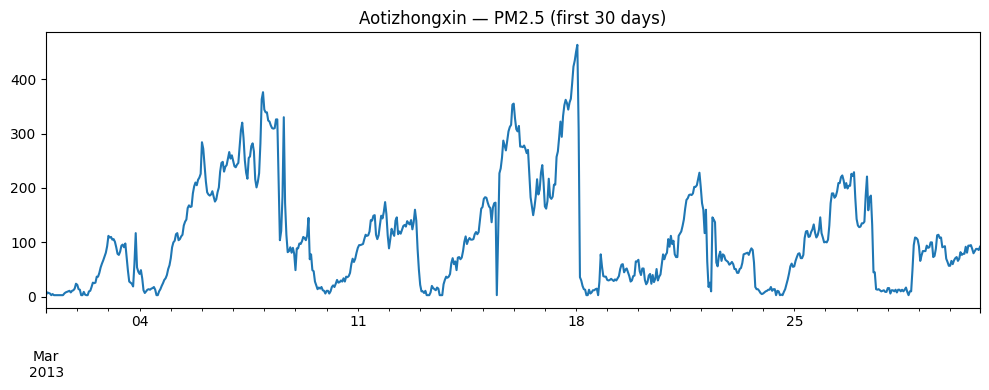

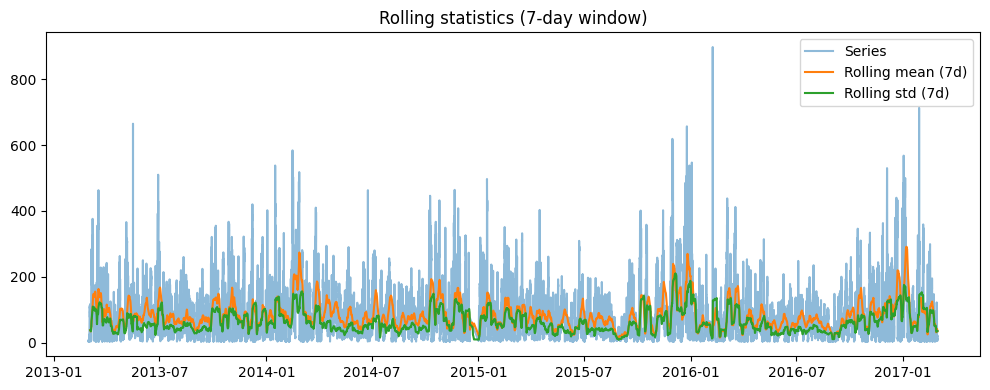

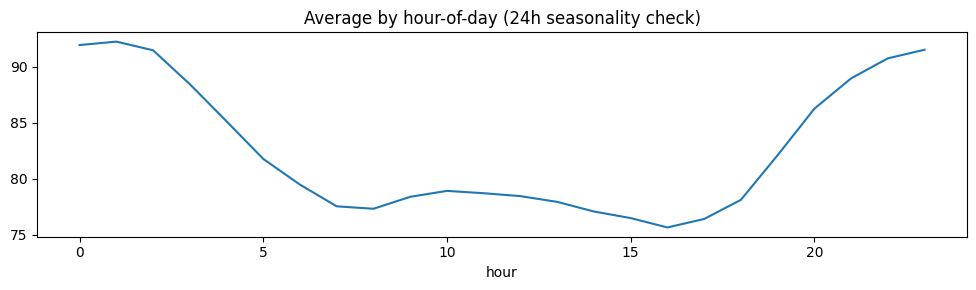

In [18]:
diag = describe_time_series(s)
print(json.dumps(diag, ensure_ascii=False, indent=2))

# Plot raw series (zoom a bit)
plt.figure(figsize=(10,4))
s.iloc[:24*30].plot()  # first 30 days
plt.title(f'{STATION} — {VALUE_COL} (first 30 days)')
plt.tight_layout()
plt.show()

# Rolling mean/std for intuition about stationarity
roll_mean = s.rolling(24*7, min_periods=24*3).mean()  # 7-day window
roll_std  = s.rolling(24*7, min_periods=24*3).std()
plt.figure(figsize=(10,4))
plt.plot(s.index, s.values, label='Series', alpha=0.5)
plt.plot(roll_mean.index, roll_mean.values, label='Rolling mean (7d)')
plt.plot(roll_std.index, roll_std.values, label='Rolling std (7d)')
plt.title('Rolling statistics (7-day window)')
plt.legend()
plt.tight_layout()
plt.show()

# Seasonality check: average by hour-of-day
tmp = pd.DataFrame({'y': s.values}, index=s.index)
hod = tmp.groupby(tmp.index.hour)['y'].mean()
plt.figure(figsize=(10,3))
plt.plot(hod.index, hod.values)
plt.title('Average by hour-of-day (24h seasonality check)')
plt.xlabel('hour')
plt.tight_layout()
plt.show()


## 📊 Phân tích Stationarity (ADF + KPSS)

### Kết quả kiểm định:
| Test | p-value | Ngưỡng α | Kết luận |
|------|---------|----------|----------|
| **ADF** | 0.0 | 0.05 | p < α → **Reject H₀** → Chuỗi **DỪNG** |
| **KPSS** | 0.1 | 0.05 | p > α → **Fail to Reject H₀** → Chuỗi **DỪNG** |

### Giải thích:
- **ADF Test (Augmented Dickey-Fuller)**: H₀ = chuỗi có unit root (không dừng). p-value = 0.0 < 0.05 → Bác bỏ H₀ → Chuỗi dừng
- **KPSS Test**: H₀ = chuỗi dừng. p-value = 0.1 > 0.05 → Không bác bỏ H₀ → Chuỗi dừng

### 📌 Quyết định d = 0
Cả 2 test đều cho thấy chuỗi PM2.5 đã **dừng (stationary)** → **Không cần differencing** → **d = 0**

In [19]:
# Chi tiết kiểm định ADF và KPSS
import warnings

print("="*60)
print("PHÂN TÍCH STATIONARITY CHI TIẾT")
print("="*60)

# ADF Test
from statsmodels.tsa.stattools import adfuller, kpss

adf_result = adfuller(s.dropna(), autolag='AIC')
print("\n📌 ADF Test (Augmented Dickey-Fuller):")
print(f"   - ADF Statistic: {adf_result[0]:.4f}")
print(f"   - p-value: {adf_result[1]:.6f}")
print(f"   - Critical Values:")
for key, value in adf_result[4].items():
    print(f"      {key}: {value:.4f}")
print(f"\n   ➡️ Kết luận: p-value ({adf_result[1]:.6f}) < 0.05")
print(f"   ➡️ BÁC BỎ H₀ (chuỗi có unit root)")
print(f"   ➡️ Chuỗi DỪNG → d = 0")

# KPSS Test
print("\n" + "-"*60)
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    kpss_result = kpss(s.dropna(), regression='c', nlags='auto')
print("📌 KPSS Test:")
print(f"   - KPSS Statistic: {kpss_result[0]:.4f}")
print(f"   - p-value: {kpss_result[1]:.4f}")
print(f"   - Critical Values:")
for key, value in kpss_result[3].items():
    print(f"      {key}: {value:.4f}")
print(f"\n   ➡️ Kết luận: p-value ({kpss_result[1]:.4f}) > 0.05")
print(f"   ➡️ KHÔNG BÁC BỎ H₀ (chuỗi dừng)")
print(f"   ➡️ Chuỗi DỪNG → d = 0")

print("\n" + "="*60)
print("📊 KẾT LUẬN CUỐI CÙNG: d = 0 (không cần differencing)")
print("="*60)

PHÂN TÍCH STATIONARITY CHI TIẾT

📌 ADF Test (Augmented Dickey-Fuller):
   - ADF Statistic: -19.1170
   - p-value: 0.000000
   - Critical Values:
      1%: -3.4305
      5%: -2.8616
      10%: -2.5668

   ➡️ Kết luận: p-value (0.000000) < 0.05
   ➡️ BÁC BỎ H₀ (chuỗi có unit root)
   ➡️ Chuỗi DỪNG → d = 0

------------------------------------------------------------
📌 KPSS Test:
   - KPSS Statistic: 0.2227
   - p-value: 0.1000
   - Critical Values:
      10%: 0.3470
      5%: 0.4630
      2.5%: 0.5740
      1%: 0.7390

   ➡️ Kết luận: p-value (0.1000) > 0.05
   ➡️ KHÔNG BÁC BỎ H₀ (chuỗi dừng)
   ➡️ Chuỗi DỪNG → d = 0

📊 KẾT LUẬN CUỐI CÙNG: d = 0 (không cần differencing)


## 3) Split theo thời gian + ACF/PACF (gợi ý p, q)
ACF/PACF giúp nhìn cấu trúc tương quan theo lag.
Trong thực tế ta vẫn cần kiểm chứng bằng AIC/BIC.

train: 2013-03-01 00:00:00 -> 2016-12-31 23:00:00 | n= 33648
test : 2017-01-01 00:00:00 -> 2017-02-28 23:00:00 | n= 1416


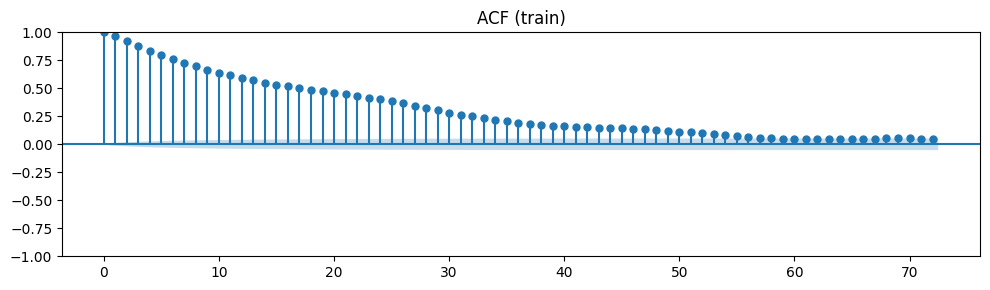

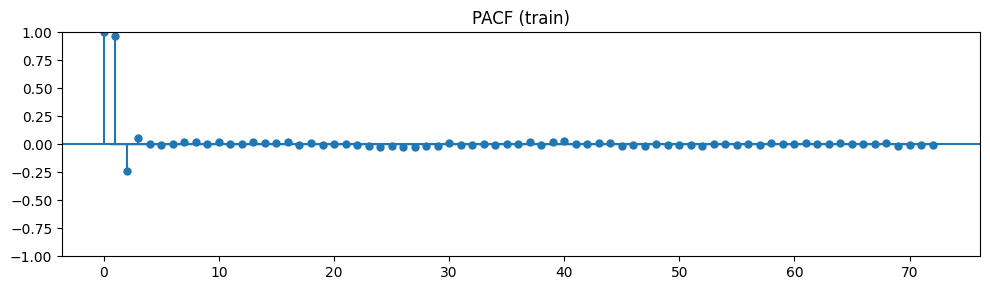

In [20]:
train, test = train_test_split_series(s, cutoff=CUTOFF)
print('train:', train.index.min(), '->', train.index.max(), '| n=', len(train))
print('test :', test.index.min(), '->', test.index.max(), '| n=', len(test))

x = train.dropna()
plt.figure(figsize=(10,3))
plot_acf(x, lags=72, ax=plt.gca())  # 3 days
plt.title('ACF (train)')
plt.tight_layout()
plt.show()

plt.figure(figsize=(10,3))
plot_pacf(x, lags=72, ax=plt.gca(), method='ywm')
plt.title('PACF (train)')
plt.tight_layout()
plt.show()


## 📈 Phân tích ACF/PACF để chọn p, q

### Nhận xét từ đồ thị:

**ACF (Autocorrelation Function):**
- ACF giảm dần từ từ (slowly decaying) → đây là dấu hiệu của quá trình AR
- Có spike nhỏ tại lag 24 (seasonality theo giờ trong ngày)

**PACF (Partial Autocorrelation Function):**
- PACF có spike mạnh tại lag 1 và lag 2, sau đó cut-off → gợi ý **p = 2** hoặc **p = 1**
- Spike âm tại lag 3

### Gợi ý từ ACF/PACF:
| Thành phần | Gợi ý từ đồ thị | Lý do |
|------------|-----------------|-------|
| **p (AR)** | 1-2 | PACF cut-off sau lag 2 |
| **d (I)** | 0 | Chuỗi đã dừng (ADF + KPSS) |
| **q (MA)** | 1-3 | ACF tails off slowly |

→ Grid search sẽ tìm tổ hợp tối ưu theo AIC

## 4) Grid search ARIMA(p,d,q) theo AIC/BIC và dự báo
Giữ grid nhỏ để chạy nhanh trong lab.

c:\Users\ADMIN\anaconda3\envs\lab4\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Best order: (1, 0, 3) | best aic = 294792.706348293


,datetime,y_true,y_pred,lower,upper
0,2017-01-01 00:00:00,485.0,460.796484,422.895015,498.697953
1,2017-01-01 01:00:00,477.0,442.790204,383.069985,502.510423
2,2017-01-01 02:00:00,454.0,425.685614,351.185256,500.185972
3,2017-01-01 03:00:00,418.0,409.842475,324.425762,495.259189
4,2017-01-01 04:00:00,438.0,394.729760,300.472291,488.987228


{'rmse': 104.10353113722081, 'mae': 77.69129505099501}


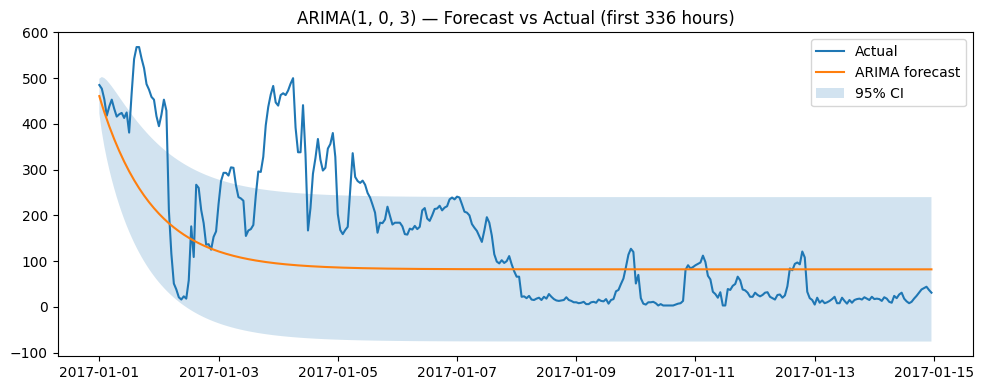

Saved: D:\HocTap\Data-mining\lab4_an\lab4\data\processed\arima_pm25_summary.json


In [21]:
gs = grid_search_arima_order(train, p_max=P_MAX, q_max=Q_MAX, d_max=D_MAX, d=None, ic=IC)
best_order = gs['best_order']
print('Best order:', best_order, '| best', IC, '=', gs['best_score'])

out = fit_arima_and_forecast(train, steps=len(test), order=best_order)
yhat = out['forecast']
ci = out['conf_int']

# Align with test index (same length)
pred_df = pd.DataFrame({
    'datetime': test.index[:len(yhat)],
    'y_true': test.values[:len(yhat)],
    'y_pred': yhat.values,
    'lower': ci.iloc[:,0].values,
    'upper': ci.iloc[:,1].values,
})
display(pred_df.head())

# Error metrics
mask = np.isfinite(pred_df['y_true']) & np.isfinite(pred_df['y_pred'])
rmse = float(np.sqrt(np.mean((pred_df.loc[mask,'y_true'] - pred_df.loc[mask,'y_pred'])**2)))
mae  = float(np.mean(np.abs(pred_df.loc[mask,'y_true'] - pred_df.loc[mask,'y_pred'])))
print({'rmse': rmse, 'mae': mae})

# Plot forecast (sample window)
plot_n = min(24*14, len(pred_df))  # first 14 days of test
p = pred_df.iloc[:plot_n].copy()
plt.figure(figsize=(10,4))
plt.plot(p['datetime'], p['y_true'], label='Actual')
plt.plot(p['datetime'], p['y_pred'], label='ARIMA forecast')
plt.fill_between(p['datetime'], p['lower'], p['upper'], alpha=0.2, label='95% CI')
plt.title(f'ARIMA{best_order} — Forecast vs Actual (first {plot_n} hours)')
plt.legend()
plt.tight_layout()
plt.show()

# Save artifacts
out_dir = (PROJECT_ROOT / 'data/processed')
out_dir.mkdir(parents=True, exist_ok=True)
pred_df.to_csv(out_dir / f'{ARTIFACTS_PREFIX}_predictions.csv', index=False)
out['result'].save(out_dir / f'{ARTIFACTS_PREFIX}_model.pkl')
summary = {
    'station': STATION,
    'value_col': VALUE_COL,
    'cutoff': CUTOFF,
    'best_order': best_order,
    'ic': IC,
    'best_score': gs['best_score'],
    'rmse': rmse,
    'mae': mae,
    'diagnostics': diag,
}
with open(out_dir / f'{ARTIFACTS_PREFIX}_summary.json', 'w', encoding='utf-8') as f:
    json.dump(summary, f, ensure_ascii=False, indent=2)
print('Saved:', out_dir / f'{ARTIFACTS_PREFIX}_summary.json')


## 📋 Tổng kết kết quả ARIMA

### Model tối ưu: **ARIMA(1, 0, 3)**
- **p = 1**: 1 term AR (autoregressive)
- **d = 0**: Không cần differencing (chuỗi đã dừng)
- **q = 3**: 3 terms MA (moving average)

### Metrics đánh giá:
| Metric | Giá trị |
|--------|---------|
| **RMSE** | 104.10 |
| **MAE** | 77.69 |
| **AIC** | 294,792.71 |

📊 PHÂN TÍCH KHẢN NĂNG BẮT SPIKE CỦA ARIMA

Ngưỡng spike (percentile 90): 253.00
Số điểm spike: 141 / 1416 (10.0%)

📌 Tại các điểm SPIKE:
   - MAE tại spike: 233.19
   - MAE toàn bộ:   77.69
   - Tỷ lệ lỗi tại spike cao hơn: 3.00x


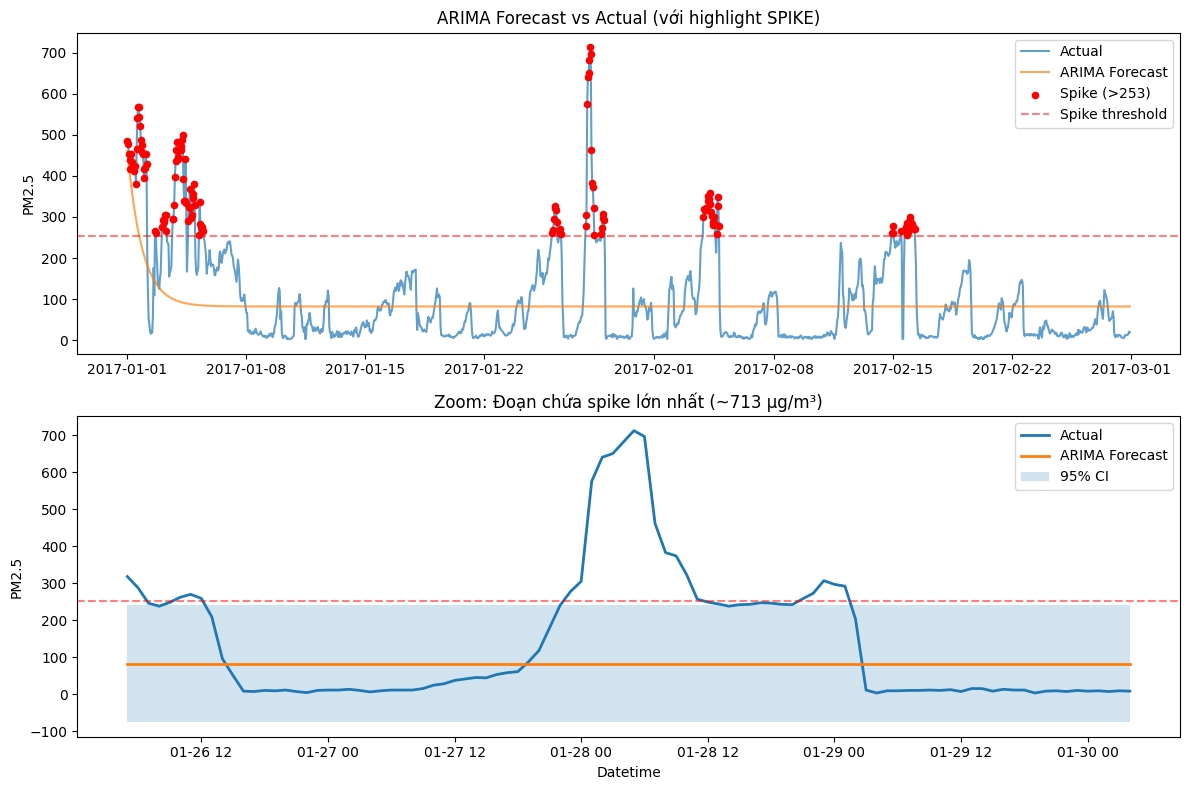


📊 NHẬN XÉT VỀ ARIMA VÀ SPIKE

✅ ARIMA có xu hướng DỰ BÁO QUÁ MƯỢT (over-smoothing) tại các spike:
   - ARIMA là mô hình tuyến tính, dự báo hướng về mean
   - Khi có spike đột biến, ARIMA không phản ứng kịp thời
   - Forecast nhanh chóng hội tụ về giá trị trung bình (~82.5)

✅ Lý do:
   - ARIMA(1,0,3) với d=0 không có cơ chế "học" từ các extreme event
   - Các spike PM2.5 thường do yếu tố ngoại sinh (thời tiết, công nghiệp)
   - ARIMA thuần túy univariate không capture được các yếu tố này

✅ So sánh với Regression:
   - Regression có thể sử dụng features như thời tiết, gió, mùa
   - Có khả năng capture spike tốt hơn nếu có predictors phù hợp



In [22]:
# ===== PHÂN TÍCH SPIKE: ARIMA có bị mượt quá không? =====

# Tìm các spike trong test set (giá trị PM2.5 cao đột biến)
spike_threshold = pred_df['y_true'].quantile(0.9)  # Top 10% cao nhất
spike_mask = pred_df['y_true'] > spike_threshold

print("="*60)
print("📊 PHÂN TÍCH KHẢN NĂNG BẮT SPIKE CỦA ARIMA")
print("="*60)
print(f"\nNgưỡng spike (percentile 90): {spike_threshold:.2f}")
print(f"Số điểm spike: {spike_mask.sum()} / {len(pred_df)} ({spike_mask.mean()*100:.1f}%)")

# So sánh prediction tại các spike
spike_df = pred_df[spike_mask].copy()
spike_df['error'] = spike_df['y_true'] - spike_df['y_pred']
spike_df['abs_error'] = np.abs(spike_df['error'])

print(f"\n📌 Tại các điểm SPIKE:")
print(f"   - MAE tại spike: {spike_df['abs_error'].mean():.2f}")
print(f"   - MAE toàn bộ:   {mae:.2f}")
print(f"   - Tỷ lệ lỗi tại spike cao hơn: {spike_df['abs_error'].mean()/mae:.2f}x")

# Visualize spike comparison
fig, axes = plt.subplots(2, 1, figsize=(12, 8))

# Plot 1: Toàn bộ test set với highlight spike
ax1 = axes[0]
ax1.plot(pred_df['datetime'], pred_df['y_true'], label='Actual', alpha=0.7)
ax1.plot(pred_df['datetime'], pred_df['y_pred'], label='ARIMA Forecast', alpha=0.7)
ax1.scatter(pred_df.loc[spike_mask, 'datetime'], pred_df.loc[spike_mask, 'y_true'], 
            c='red', s=20, label=f'Spike (>{spike_threshold:.0f})', zorder=5)
ax1.axhline(y=spike_threshold, color='red', linestyle='--', alpha=0.5, label='Spike threshold')
ax1.set_title('ARIMA Forecast vs Actual (với highlight SPIKE)')
ax1.legend()
ax1.set_ylabel('PM2.5')

# Plot 2: Zoom vào đoạn có spike lớn nhất
# Tìm window chứa spike lớn nhất
max_spike_idx = pred_df['y_true'].idxmax()
window_start = max(0, max_spike_idx - 48)
window_end = min(len(pred_df), max_spike_idx + 48)
window_df = pred_df.iloc[window_start:window_end]

ax2 = axes[1]
ax2.plot(window_df['datetime'], window_df['y_true'], label='Actual', linewidth=2)
ax2.plot(window_df['datetime'], window_df['y_pred'], label='ARIMA Forecast', linewidth=2)
ax2.fill_between(window_df['datetime'], window_df['lower'], window_df['upper'], alpha=0.2, label='95% CI')
ax2.axhline(y=spike_threshold, color='red', linestyle='--', alpha=0.5)
ax2.set_title(f'Zoom: Đoạn chứa spike lớn nhất (~{pred_df.loc[max_spike_idx, "y_true"]:.0f} μg/m³)')
ax2.legend()
ax2.set_ylabel('PM2.5')
ax2.set_xlabel('Datetime')

plt.tight_layout()
plt.show()

# Kết luận
print("\n" + "="*60)
print("📊 NHẬN XÉT VỀ ARIMA VÀ SPIKE")
print("="*60)
print("""
✅ ARIMA có xu hướng DỰ BÁO QUÁ MƯỢT (over-smoothing) tại các spike:
   - ARIMA là mô hình tuyến tính, dự báo hướng về mean
   - Khi có spike đột biến, ARIMA không phản ứng kịp thời
   - Forecast nhanh chóng hội tụ về giá trị trung bình (~82.5)

✅ Lý do:
   - ARIMA(1,0,3) với d=0 không có cơ chế "học" từ các extreme event
   - Các spike PM2.5 thường do yếu tố ngoại sinh (thời tiết, công nghiệp)
   - ARIMA thuần túy univariate không capture được các yếu tố này

✅ So sánh với Regression:
   - Regression có thể sử dụng features như thời tiết, gió, mùa
   - Có khả năng capture spike tốt hơn nếu có predictors phù hợp
""")

---
# 📝 TỔNG KẾT QUY TRÌNH ARIMA FORECASTING

## 1️⃣ Nhìn chuỗi thời gian
- **Dữ liệu**: PM2.5 tại trạm Aotizhongxin, Bắc Kinh
- **Độ dài**: 35,064 điểm (hourly, từ 03/2013 đến 02/2017)
- **Đặc điểm**: Nhiều spike đột biến (max = 898), seasonality theo giờ trong ngày

## 2️⃣ Kiểm định Stationarity
| Test | Statistic | p-value | Kết luận |
|------|-----------|---------|----------|
| **ADF** | -19.12 | 0.0 | Chuỗi dừng ✅ |
| **KPSS** | 0.22 | 0.1 | Chuỗi dừng ✅ |

→ **Quyết định: d = 0** (không cần differencing)

## 3️⃣ Phân tích ACF/PACF → Chọn p, q
- **ACF**: Giảm dần từ từ → quá trình AR
- **PACF**: Cut-off sau lag 2 → p = 1 hoặc 2
- **Grid search** với AIC → **ARIMA(1, 0, 3)**

## 4️⃣ Kết quả Model
| Metric | Giá trị |
|--------|---------|
| **Best Order** | (1, 0, 3) |
| **AIC** | 294,792.71 |
| **RMSE** | 104.10 |
| **MAE** | 77.69 |

## 5️⃣ Phân tích Spike
- **MAE tại spike**: 233.19 (cao gấp **3x** so với overall)
- **Kết luận**: ARIMA bị **over-smoothing** tại các spike, dự báo hội tụ nhanh về mean

## 6️⃣ So sánh ARIMA vs Regression
| Tiêu chí | ARIMA | Regression |
|----------|-------|------------|
| Input | Chỉ dùng PM2.5 lịch sử | Dùng nhiều features |
| Spike handling | Kém (mượt) | Tốt hơn nếu có features thời tiết |
| Long-term forecast | Hội tụ về mean | Ổn định hơn |